<a href="https://colab.research.google.com/github/carturo6/Covid-19/blob/master/LSTM_COVID_19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **I.A. DeepLearnin para Casos Covid-19**

Este respositorio tiene el fin de predecir los proximo casos de Covid19 en México ( Nivel nacional ).

Los datos que se ocuparan, son los datos disponibles en paginas del Gobierno.
Se utilizaran solo tecnicas de Deep Learning donde cada modelo podra ir variando en funcion que los datos predichos mejor se ajusten a los datos predictorios.

**Objetivo de las redes neuronales**

El objetivo de los modelos que se construiran, sera, que mejor se ajusten a los datos de test (Prueba) para poder predecir los datos del futuro. En funcion de que mejor se ajusten, sigfinicara que el entrenamiento sera exitoso.

Se ocuparan modelos de Deep Learning, para ajustarse a los datos y tener buenos resultados. La tecnica que mas probable se ajusta a las predicciones de series de tiempo, es LSTM (**Long Short Term Memory**).

## **Librerias**


Las librerias que se ocupan son las siguientes:

- Pandas: Para poder leer los archivos csv o en algun otro formato, asi como para poder manipular los datos.

- Matplotlib: Para generar graficos y asi poder entender mejor el comportamiento de la pandemia en Mexico.

- Numpy: Para poder realizar calculo que se puedan requerir o calculo de matrices

- Seaborn: Para generar graficos estadisticos con una mejor referencia de los datos

- Tensorflow: Para poder generar predicciones con redes nueronales de esta libreria

- Keras: Generar CNN para las predicciones

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sc
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import tensorflow as tf
from keras import metrics
from tensorflow import keras


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## **Importacion de datos**


Los datos ocupados en este trabajo, se tomaron de la siguiente pagina web: 

Este dataset contempla los datos disponibles de varios paises, pero simplemente se filtraran los datos correspondientes a Mexico.


In [2]:
# Carga del Dataset
df = pd.read_csv('/content/drive/MyDrive/GitHub/LSTM-Covid-19/owid-covid-data.csv')

In [3]:
# Filtrando los datos, solo para Mexico
df_mx = df[df['location'] == 'Mexico']
#Mostrando el resultado
df_mx.head(5)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,new_vaccinations_smoothed_per_million,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
45393,MEX,North America,Mexico,2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.0,25.0,0.000,0.000,NaN,NaN,NaN,NaN,people tested,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,128932753.0,66.444,29.3,6.857,4.321,17336.469,2.5,152.783,13.06,6.9,21.4,87.847,1.38,75.05,0.779
45394,MEX,North America,Mexico,2020-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,72.0,97.0,0.001,0.001,NaN,NaN,NaN,NaN,people tested,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,128932753.0,66.444,29.3,6.857,4.321,17336.469,2.5,152.783,13.06,6.9,21.4,87.847,1.38,75.05,0.779
45395,MEX,North America,Mexico,2020-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89.0,186.0,0.001,0.001,NaN,NaN,NaN,NaN,people tested,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,128932753.0,66.444,29.3,6.857,4.321,17336.469,2.5,152.783,13.06,6.9,21.4,87.847,1.38,75.05,0.779
45396,MEX,North America,Mexico,2020-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45.0,231.0,0.002,0.000,NaN,NaN,NaN,NaN,people tested,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,128932753.0,66.444,29.3,6.857,4.321,17336.469,2.5,152.783,13.06,6.9,21.4,87.847,1.38,75.05,0.779
45397,MEX,North America,Mexico,2020-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,85.0,316.0,0.002,0.001,NaN,NaN,NaN,NaN,people tested,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,128932753.0,66.444,29.3,6.857,4.321,17336.469,2.5,152.783,13.06,6.9,21.4,87.847,1.38,75.05,0.779


In [4]:
# Seleccionando columnas
df_mx = df_mx.iloc[:, 3:6]
df_mx.head()

,date,total_cases,new_cases
45393,2020-01-01,NaN,NaN
45394,2020-01-02,NaN,NaN
45395,2020-01-03,NaN,NaN
45396,2020-01-04,NaN,NaN
45397,2020-01-05,NaN,NaN


In [5]:
#Reseteando index
df_mx = df_mx.reset_index(inplace=False)
#Eliminando columna extra
del df_mx['index']
#Mostrando datos
df_mx.head(3)

,date,total_cases,new_cases
0,2020-01-01,NaN,NaN
1,2020-01-02,NaN,NaN
2,2020-01-03,NaN,NaN


In [6]:
# Trabajando con la columna de nuevos casos
df_mx = df_mx.iloc[:,[0,2]]
df_mx.head()

,date,new_cases
0,2020-01-01,NaN
1,2020-01-02,NaN
2,2020-01-03,NaN
3,2020-01-04,NaN
4,2020-01-05,NaN


Asi seran los datos con los que se trabajaran. 

Como se muestran en la tabla de arriba.

## **Transformacion de los datos**

Es importante considerar, que para poder realizar predicciones, los datos debe de tener una forma correcta, es decir:


- No tener datos faltantes
- La fecha sera de tipo datetime
- Los datos de "nuevo casos" son datos numericos


---


Realizar un analisis estadistico, es importante para poder contemplar el comportamineto de los daots.





In [7]:
df_mx.head(3)

,date,new_cases
0,2020-01-01,NaN
1,2020-01-02,NaN
2,2020-01-03,NaN


In [8]:
df_mx.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 454 entries, 0 to 453
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       454 non-null    object 
 1   new_cases  396 non-null    float64
dtypes: float64(1), object(1)
memory usage: 7.2+ KB


In [9]:
df_mx.date = pd.to_datetime(df_mx.date)

In [10]:
df_mx.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 454 entries, 0 to 453
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       454 non-null    datetime64[ns]
 1   new_cases  396 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 7.2 KB


In [11]:
#Analisis estadistico rapido
df_mx.describe()

,new_cases
count,396.000000
mean,5625.866162
std,4475.211614
min,0.000000
25%,2800.250000
50%,5237.500000
75%,6848.500000
max,28115.000000


In [12]:
df_mx.isna().sum()

date          0
new_cases    58
dtype: int64

In [13]:
# Quitando Datos faltantes.
df_mx = df_mx[df_mx['new_cases'].notna()]

In [14]:
df_mx.tail()

,date,new_cases
449,2021-03-25,5787.0
450,2021-03-26,5303.0
451,2021-03-27,5059.0
452,2021-03-28,1646.0
453,2021-03-29,1293.0


In [15]:
df_mx.date.describe()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


count                     396
unique                    396
top       2020-04-13 00:00:00
freq                        1
first     2020-02-28 00:00:00
last      2021-03-29 00:00:00
Name: date, dtype: object


---


---


## **Visualizacion de Datos**


Es muy importante poder ver los datos de manera grafica, asi se podra tener vision mas clara del comportamiento de los datos.

Al tratar con datos, que se trabajaran como series temporales, existe un tipo de grafico que mas se adopta a estos mismos. Plotear datos es una forma clara para ver su comportamiento. 

Por el eje de las x, tenemos el tiempo, los dias o meses que han transcurrido. En el eje de las y, tenemos la cantidad de casos nuevos, de esta forma es como se puede ver su comportamiento.

**Para la tendencia. Los datos se trabajaran con una serie de tiempo de 7 dias (1 semana), para acomular la mayor cantidad de datos y aun asi podamos tener buenas predicciones**

En las graficas se trabajan con las series temporales de 7 dias juntos.

In [16]:
#Copiando dataset
df_mx_2 = df_mx.copy()

In [17]:
df_mx_2.set_index('date', inplace=True)

In [18]:
# Promedio de ventanas de tiempo

#Ventana de tiempo
ventana_tiempo = df_mx_2.rolling(7)

#Media de la ventana de tiempo
media_df = ventana_tiempo.mean()

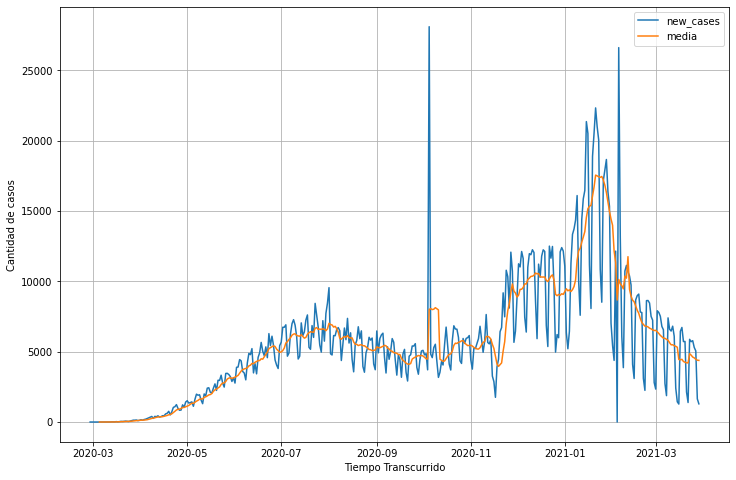

In [19]:
plt.figure(figsize=(12,8))
plt.plot(df_mx_2, label='new_cases')
plt.plot(media_df, label='media')
plt.ylabel('Cantidad de casos')
plt.xlabel('Tiempo Transcurrido')
plt.grid()
plt.legend()

**Los datos presentados en la grafica presentan algunos outliers (datos fuera de lo normal), estos datos se pueden ver en la grafica de arribsa, entre el mes 09 y 11. Tambien entre 2021-01 y 2021-03. Estos datos son muy notorios ya que tienen una exageración dentro de la grafica.**



**Pero para poder observar otra perseptiva de los datos, veremos su tendencia, ya que la tendencia podra revelar los datos aun mas claros.**

In [20]:
seasonal_value = seasonal_decompose(df_mx_2, freq=7)

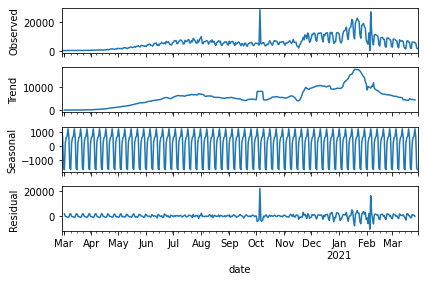

In [21]:
seasonal_value.plot();

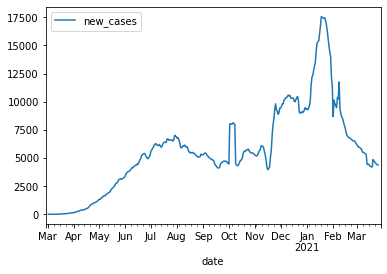

In [22]:
seasonal_value.trend.plot()

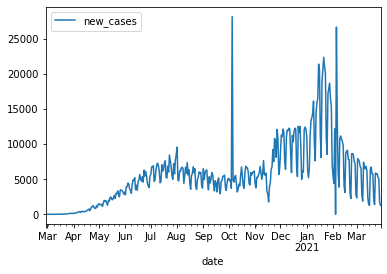

In [23]:
seasonal_value.observed.plot()

# **Escalando datos**

Preparando los datos para poder introducirlos a las diferetnes redes nueronales

- Unas vez visualizados algunos de los datos, procederemos a realizar una division de los datos, en 2 conjuntos, entreanmiento y prueba. De esta forma tendremos una mejor prediccion, para poder tener una referenecia entre los datos de testeo y las predicciones. Asi se podra observar como sera la sertesa de la prediccion vs datos reales.

- De manera mas practica y con la intencion de tener una mejor idea, los resultados se estaran ploteando(graficando) y asi ver como nos asercamos a las predicciones.

- Para todos los datos para predecir tomaremos unicamente 20 dias para predecir en el futuro. 20 datos son los que apartaremos para testeo.

In [60]:
# Datos de entreamiento y test

len(df_mx_2)

396

In [61]:
len(df_mx_2)-20

376

In [62]:
#Division de los datos de entrenamiento y test
train = df_mx_2.iloc[:len(df_mx_2)-20]
test = df_mx_2.iloc[len(df_mx_2)-20:]

In [27]:
# Escalando datos

from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator

scaler = MinMaxScaler()

In [28]:
#Ajustando los datos de entrenamiento
scaler.fit(train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [29]:
#Datos escalados

scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [30]:
# Generator
n_input = 20
n_feacture = 1

generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=2)

x, y = generator[0]

# **Modelo-1**

In [31]:
# Red neuronal

#Red sequential
model_1 = Sequential()

#Red nueronal con 4 capas, cada capa tiene dierente cantidad de nueronas
model_1.add(LSTM(128, activation='relu', input_shape=(n_input, n_feacture)))
model_1.add(Dense(64, activation='relu' ))
model_1.add(Dense(32))
model_1.add(Dense(1))

#Compilacion de la red nueronal
model_1.compile(optimizer='adam', loss='mean_squared_error')

In [32]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               66560     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 76,929
Trainable params: 76,929
Non-trainable params: 0
_________________________________________________________________


In [33]:
#Entrenando la red nueronal

model_1.fit_generator(generator, epochs=100)

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


178/178 [==============================] - 4s 14ms/step - loss: 0.0326
Epoch 2/100
178/178 [==============================] - 2s 14ms/step - loss: 0.0115
Epoch 3/100
178/178 [==============================] - 2s 14ms/step - loss: 0.0074
Epoch 4/100
178/178 [==============================] - 2s 14ms/step - loss: 0.0093
Epoch 5/100
178/178 [==============================] - 2s 14ms/step - loss: 0.0086
Epoch 6/100
178/178 [==============================] - 2s 14ms/step - loss: 0.0074
Epoch 7/100
178/178 [==============================] - 2s 14ms/step - loss: 0.0098
Epoch 8/100
178/178 [==============================] - 2s 13ms/step - loss: 0.0155
Epoch 9/100
178/178 [==============================] - 2s 14ms/step - loss: 0.0074
Epoch 10/100
178/178 [==============================] - 2s 14ms/step - loss: 0.0110
Epoch 11/100
178/178 [==============================] - 2s 13ms/step - loss: 0.0092
Epoch 12/100
178/178 [==============================] - 2s 14ms/step - loss: 0.0129
Epoch 13/100


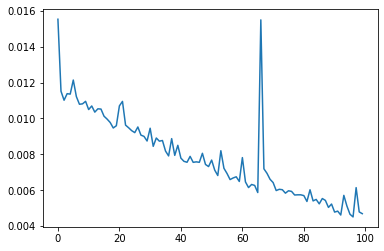

In [34]:
loss_pre_epoch = model_1.history.history['loss']
plt.plot(range(len(loss_pre_epoch)), loss_pre_epoch)

In [35]:
first_eval = scaled_train[-20:]


first_eval = first_eval.reshape(1, n_input, n_feacture)

model_1.predict(first_eval)

array([[0.2326291]], dtype=float32)

In [36]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval.reshape((1, n_input, n_feacture))

for i in range(len(test)):
    
    # obtener la predicción ([0] es para obtener solo el número en lugar de [matriz])
    current_pred = model_1.predict(current_batch)[0]
    
    # guardar la predicción
    test_predictions.append(current_pred) 
    
    # actualizar el lote para incluir ahora la predicción y soltar primer valor
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [37]:
#Transofmacion inversa
true_predicctions = scaler.inverse_transform(test_predictions)


test['Prediction'] = true_predicctions

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


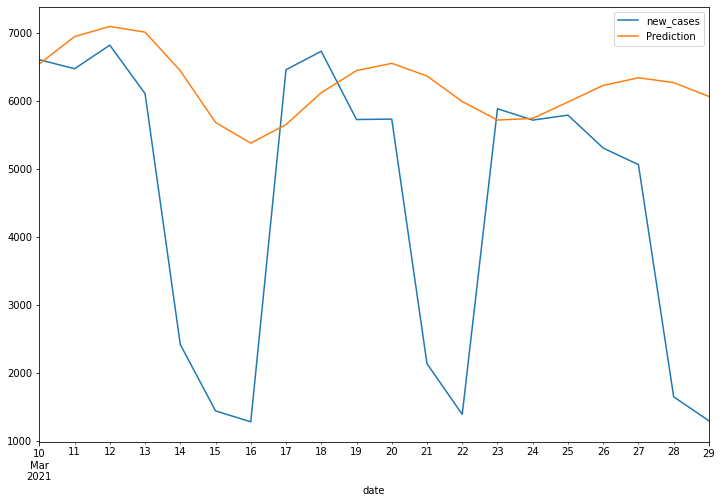

In [38]:
test.plot(figsize=(12,8))

In [39]:
#Observacion de los test y la predicciones
test

,new_cases,Prediction
date,,
2021-03-10,6602.0,6540.367300
2021-03-11,6469.0,6941.951899
2021-03-12,6816.0,7090.299892
2021-03-13,6104.0,7007.388355
2021-03-14,2415.0,6439.584358
2021-03-15,1439.0,5680.156907
2021-03-16,1278.0,5375.331271
2021-03-17,6455.0,5648.197181
2021-03-18,6726.0,6116.851288


# **Modelo 2**

In [40]:
# Red neuronal 2
# 5 Capas
# relu para activacion de cada capa
# sgd para compilacion y mse para loss

#Red sequential
model_2 = Sequential()

#Red nueronal con 4 capas, cada capa tiene dierente cantidad de nueronas
model_2.add(LSTM(128, activation='relu', input_shape=(n_input, n_feacture)))
model_2.add(Dense(64, activation='relu' ))
model_2.add(Dense(32, activation='relu'))
model_2.add(Dense(12))
model_2.add(Dense(1))

#Compilacion de la red nueronal
model_2.compile(optimizer='sgd', loss='mean_squared_error', )

In [41]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               66560     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 12)                396       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 13        
Total params: 77,305
Trainable params: 77,305
Non-trainable params: 0
_________________________________________________________________


In [42]:
#Entrenando la red nueronal

model_2.fit_generator(generator, epochs=100)

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


178/178 [==============================] - 4s 13ms/step - loss: 0.0290
Epoch 2/100
178/178 [==============================] - 2s 13ms/step - loss: 0.0171
Epoch 3/100
178/178 [==============================] - 2s 13ms/step - loss: 0.0162
Epoch 4/100
178/178 [==============================] - 2s 13ms/step - loss: 0.0200
Epoch 5/100
178/178 [==============================] - 2s 14ms/step - loss: 0.0117
Epoch 6/100
178/178 [==============================] - 2s 14ms/step - loss: 0.0139
Epoch 7/100
178/178 [==============================] - 2s 13ms/step - loss: 0.0118
Epoch 8/100
178/178 [==============================] - 2s 13ms/step - loss: 0.0128
Epoch 9/100
178/178 [==============================] - 2s 13ms/step - loss: 0.0096
Epoch 10/100
178/178 [==============================] - 2s 13ms/step - loss: 0.0123
Epoch 11/100
178/178 [==============================] - 2s 13ms/step - loss: 0.0110
Epoch 12/100
178/178 [==============================] - 2s 13ms/step - loss: 0.0118
Epoch 13/100


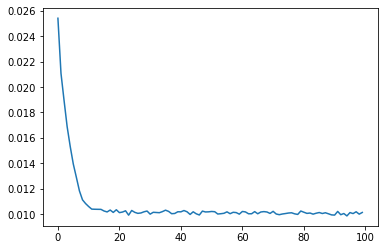

In [43]:
loss_pre_epoch = model_2.history.history['loss']
plt.plot(range(len(loss_pre_epoch)), loss_pre_epoch)

In [44]:
first_eval = scaled_train[-20:]


first_eval = first_eval.reshape(1, n_input, n_feacture)

model_2.predict(first_eval)

array([[0.21603231]], dtype=float32)

In [45]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval.reshape((1, n_input, n_feacture))

for i in range(len(test)):
    
    # obtener la predicción ([0] es para obtener solo el número en lugar de [matriz])
    current_pred = model_2.predict(current_batch)[0]
    
    # guardar la predicción
    test_predictions.append(current_pred) 
    
    # actualizar el lote para incluir ahora la predicción y soltar primer valor
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [46]:
#Transofmacion inversa
true_predicctions_2 = scaler.inverse_transform(test_predictions)


test['Prediction_2'] = true_predicctions_2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


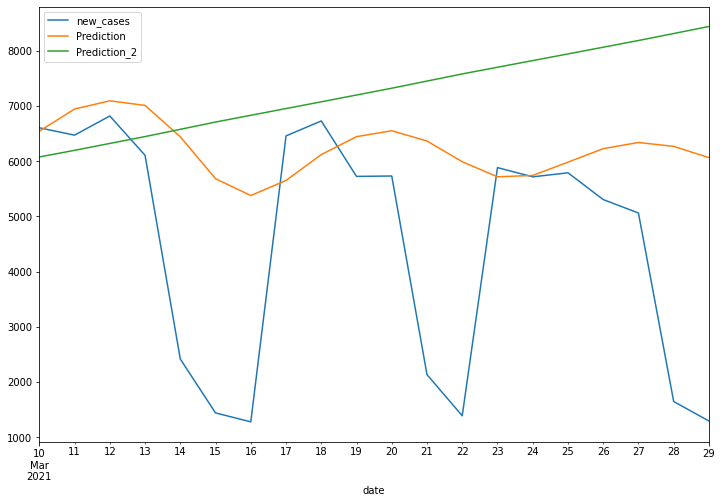

In [47]:
test.plot(figsize=(12,8))

In [48]:
#Observacion de los test y la predicciones
test

,new_cases,Prediction,Prediction_2
date,,,
2021-03-10,6602.0,6540.367300,6073.748433
2021-03-11,6469.0,6941.951899,6194.118783
2021-03-12,6816.0,7090.299892,6318.813914
2021-03-13,6104.0,7007.388355,6443.252231
2021-03-14,2415.0,6439.584358,6574.336710
2021-03-15,1439.0,5680.156907,6706.323180
2021-03-16,1278.0,5375.331271,6828.497931
2021-03-17,6455.0,5648.197181,6950.399948
2021-03-18,6726.0,6116.851288,7072.375700


# **Modeo 3**

In [49]:
# Red neuronal 3
# 5 Capas
# relu para activacion de cada capa
# sgd para compilacion y mse para loss

#Red sequential
model_3 = Sequential()

#Red nueronal con 4 capas, cada capa tiene dierente cantidad de nueronas
model_3.add(LSTM(168, activation='relu', input_shape=(n_input, n_feacture)))
model_3.add(Dense(124, activation='relu' ))
model_3.add(Dense(64, activation='relu'))
model_3.add(Dense(32))
model_3.add(Dense(1))

#Compilacion de la red nueronal
model_3.compile(optimizer='sgd', loss='mean_squared_error',
                metrics=[metrics.mae,
                metrics.categorical_accuracy])

In [50]:
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 168)               114240    
_________________________________________________________________
dense_7 (Dense)              (None, 124)               20956     
_________________________________________________________________
dense_8 (Dense)              (None, 64)                8000      
_________________________________________________________________
dense_9 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 33        
Total params: 145,309
Trainable params: 145,309
Non-trainable params: 0
_________________________________________________________________


In [51]:
#Entrenando la red nueronal

model_3.fit_generator(generator, epochs=100)

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


178/178 [==============================] - 5s 18ms/step - loss: 0.0306 - mean_absolute_error: 0.1278 - categorical_accuracy: 1.0000
Epoch 2/100
178/178 [==============================] - 3s 18ms/step - loss: 0.0203 - mean_absolute_error: 0.1002 - categorical_accuracy: 1.0000
Epoch 3/100
178/178 [==============================] - 3s 18ms/step - loss: 0.0232 - mean_absolute_error: 0.1001 - categorical_accuracy: 1.0000
Epoch 4/100
178/178 [==============================] - 3s 18ms/step - loss: 0.0211 - mean_absolute_error: 0.0936 - categorical_accuracy: 1.0000
Epoch 5/100
178/178 [==============================] - 3s 18ms/step - loss: 0.0124 - mean_absolute_error: 0.0791 - categorical_accuracy: 1.0000
Epoch 6/100
178/178 [==============================] - 3s 18ms/step - loss: 0.0145 - mean_absolute_error: 0.0852 - categorical_accuracy: 1.0000
Epoch 7/100
178/178 [==============================] - 3s 18ms/step - loss: 0.0151 - mean_absolute_error: 0.0813 - categorical_accuracy: 1.0000
Epoc

In [52]:
first_eval_3 = scaled_train[-20:]


first_eval_3 = first_eval_3.reshape(1, n_input, n_feacture)

model_3.predict(first_eval_3)

array([[0.23853663]], dtype=float32)

In [53]:
test_predictions_3 = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_3.reshape((1, n_input, n_feacture))

for i in range(len(test)):
    
    # obtener la predicción ([0] es para obtener solo el número en lugar de [matriz])
    current_pred = model_3.predict(current_batch)[0]
    
    # guardar la predicción
    test_predictions_3.append(current_pred) 
    
    # actualizar el lote para incluir ahora la predicción y soltar primer valor
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [54]:
#Transofmacion inversa
true_predicctions_3 = scaler.inverse_transform(test_predictions_3)


test['Prediction_3'] = true_predicctions_3

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


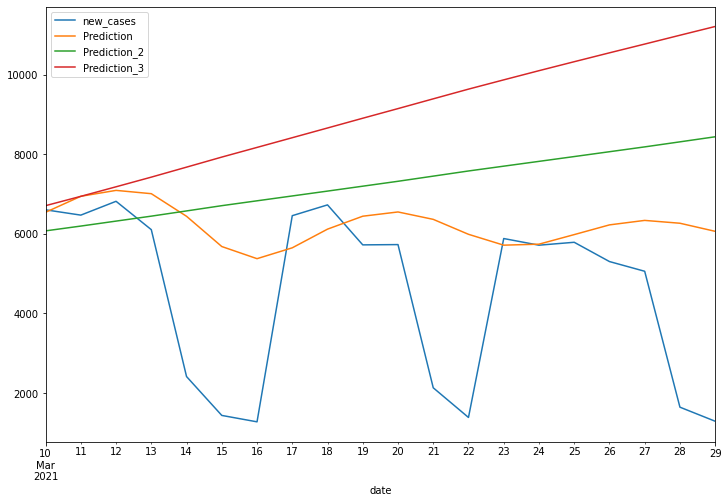

In [55]:
test.plot(figsize=(12,8))

In [56]:
#Observacion de los test y la predicciones
test

,new_cases,Prediction,Prediction_2,Prediction_3
date,,,,
2021-03-10,6602.0,6540.367300,6073.748433,6706.457243
2021-03-11,6469.0,6941.951899,6194.118783,6940.477628
2021-03-12,6816.0,7090.299892,6318.813914,7180.567705
2021-03-13,6104.0,7007.388355,6443.252231,7422.973297
2021-03-14,2415.0,6439.584358,6574.336710,7673.925391
2021-03-15,1439.0,5680.156907,6706.323180,7926.446019
2021-03-16,1278.0,5375.331271,6828.497931,8169.372780
2021-03-17,6455.0,5648.197181,6950.399948,8413.115648
2021-03-18,6726.0,6116.851288,7072.375700,8657.047880


# **Modelo 4**

In [57]:
# Red neuronal 4
# 5 Capas
# relu para activacion de cada capa
# adam para compilacion y mse para loss

#Red sequential
model_4 = Sequential()

#Red nueronal con 4 capas, cada capa tiene dierente cantidad de nueronas
model_4.add(LSTM(200, activation='relu', input_shape=(n_input, n_feacture)))
model_4.add(Dense(100, activation='relu' ))
model_4.add(Dense(84, activation='relu'))
model_4.add(Dense(32, activation='relu'))
model_4.add(Dense(32))
model_4.add(Dense(1))

#Compilacion de la red nueronal
model_4.compile(optimizer='adam', loss='mean_squared_error',
                metrics=[metrics.mae,
                metrics.categorical_accuracy])

In [58]:
model_4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 200)               161600    
_________________________________________________________________
dense_11 (Dense)             (None, 100)               20100     
_________________________________________________________________
dense_12 (Dense)             (None, 84)                8484      
_________________________________________________________________
dense_13 (Dense)             (None, 32)                2720      
_________________________________________________________________
dense_14 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 33        
Total params: 193,993
Trainable params: 193,993
Non-trainable params: 0
________________________________________________

In [59]:
#Entrenando la red nueronal

model_4.fit_generator(generator, epochs=200)

Epoch 1/200


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


178/178 [==============================] - 5s 22ms/step - loss: 0.0172 - mean_absolute_error: 0.0942 - categorical_accuracy: 1.0000
Epoch 2/200
178/178 [==============================] - 4s 22ms/step - loss: 0.0109 - mean_absolute_error: 0.0708 - categorical_accuracy: 1.0000
Epoch 3/200
178/178 [==============================] - 4s 22ms/step - loss: 0.0133 - mean_absolute_error: 0.0713 - categorical_accuracy: 1.0000
Epoch 4/200
178/178 [==============================] - 4s 22ms/step - loss: 0.0138 - mean_absolute_error: 0.0696 - categorical_accuracy: 1.0000
Epoch 5/200
178/178 [==============================] - 4s 23ms/step - loss: 0.0105 - mean_absolute_error: 0.0666 - categorical_accuracy: 1.0000
Epoch 6/200
178/178 [==============================] - 4s 23ms/step - loss: 0.0148 - mean_absolute_error: 0.0788 - categorical_accuracy: 1.0000
Epoch 7/200
178/178 [==============================] - 4s 23ms/step - loss: 0.0093 - mean_absolute_error: 0.0614 - categorical_accuracy: 1.0000
Epoc

_NotOkStatusException: ignored

In [ ]:
first_eval_4 = scaled_train[-20:]


first_eval_4 = first_eval_4.reshape(1, n_input, n_feacture)

model_4.predict(first_eval_4)

In [ ]:
test_predictions_4 = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_4.reshape((1, n_input, n_feacture))

for i in range(len(test)):
    
    # obtener la predicción ([0] es para obtener solo el número en lugar de [matriz])
    current_pred = model_4.predict(current_batch)[0]
    
    # guardar la predicción
    test_predictions_4.append(current_pred) 
    
    # actualizar el lote para incluir ahora la predicción y soltar primer valor
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [ ]:
#Transofmacion inversa
true_predicctions_4 = scaler.inverse_transform(test_predictions_4)


test['Prediction_4'] = true_predicctions_4

In [ ]:
test.plot(figsize=(12,8))

In [ ]:
#Observacion de los test y la predicciones
test

# **Model 5**

In [ ]:
# Red neuronal 5
# 5 Capas
# relu para activacion de cada capa
# adam para compilacion y mse para loss

#Red sequential
model_5 = Sequential()

#Red nueronal con 4 capas, cada capa tiene dierente cantidad de nueronas
model_5.add(LSTM(200, activation='relu', input_shape=(n_input, n_feacture)))
model_5.add(Dense(100, activation='relu' ))
model_5.add(Dense(84, activation='relu'))
model_5.add(Dense(64, activation='relu'))
model_5.add(Dense(32, activation='sigmoid'))
model_5.add(Dense(1))

#Compilacion de la red nueronal
model_5.compile(optimizer='adam', loss='mean_squared_error',
                metrics=["accuracy"])

In [ ]:
model_5.summary()

In [ ]:
#Entrenando la red nueronal

model_5.fit_generator(generator, epochs=200)

In [ ]:
first_eval_5 = scaled_train[-20:]


first_eval_5 = first_eval_5.reshape(1, n_input, n_feacture)

model_5.predict(first_eval_5)

In [ ]:
test_predictions_5 = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_5.reshape((1, n_input, n_feacture))

for i in range(len(test)):
    
    # obtener la predicción ([0] es para obtener solo el número en lugar de [matriz])
    current_pred = model_5.predict(current_batch)[0]
    
    # guardar la predicción
    test_predictions_5.append(current_pred) 
    
    # actualizar el lote para incluir ahora la predicción y soltar primer valor
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [ ]:
#Transofmacion inversa
true_predicctions_5 = scaler.inverse_transform(test_predictions_5)


test['Prediction_5'] = true_predicctions_5

In [ ]:
test[['new_cases', 'Prediction_5']].plot(figsize=(12,8))

In [ ]:
#Observacion de los test y la predicciones
test

# **Modelo 6**

In [ ]:
# Red neuronal 6
# 5 Capas
# relu para activacion de cada capa
# adam para compilacion y mse para loss

#Red sequential
model_6 = Sequential()

#Red nueronal con 4 capas, cada capa tiene dierente cantidad de nueronas
model_6.add(LSTM(200, activation='relu', input_shape=(n_input, n_feacture)))
model_6.add(Dense(150, activation='relu' ))
model_6.add(Dense(100, activation='relu'))
model_6.add(Dense(80, activation='relu'))
model_6.add(Dense(64, activation='relu'))
model_6.add(Dense(32, activation='sigmoid'))
model_6.add(Dense(1))

#Compilacion de la red nueronal
model_6.compile(optimizer='adam', loss='mean_squared_error',
                metrics=["accuracy"])

In [ ]:
model_6.summary()

In [ ]:
#Entrenando la red nueronal

model_6.fit_generator(generator, epochs=250)

In [ ]:
first_eval_6 = scaled_train[-20:]


first_eval_6 = first_eval_6.reshape(1, n_input, n_feacture)

model_6.predict(first_eval_6)

In [ ]:
test_predictions_6 = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_6.reshape((1, n_input, n_feacture))

for i in range(len(test)):
    
    # obtener la predicción ([0] es para obtener solo el número en lugar de [matriz])
    current_pred = model_6.predict(current_batch)[0]
    
    # guardar la predicción
    test_predictions_6.append(current_pred) 
    
    # actualizar el lote para incluir ahora la predicción y soltar primer valor
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [ ]:
#Transofmacion inversa
true_predicctions_6 = scaler.inverse_transform(test_predictions_6)


test['Prediction_6'] = true_predicctions_6

In [ ]:
test[['new_cases', 'Prediction_6']].plot(figsize=(12,8))

In [ ]:
#Observacion de los test y la predicciones
test

# **Modelo 7**

In [ ]:
66/2

In [ ]:
# Red neuronal 7
# 5 Capas
# relu para activacion de cada capa
# adam para compilacion y mse para loss

#Red sequential
model_7 = Sequential()

#Red nueronal con 4 capas, cada capa tiene dierente cantidad de nueronas
model_7.add(LSTM(120, activation='relu', input_shape=(n_input, n_feacture)))
model_7.add(Dense(100, activation='relu' ))
model_7.add(Dense(68, activation='relu' ))
model_7.add(Dense(34, activation='sigmoid' ))
model_7.add(Dense(16, activation='sigmoid' ))
model_7.add(Dense(1))

#Compilacion de la red nueronal
model_7.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001) , loss='mse',
                metrics=["accuracy"])

In [ ]:
model_7.summary()

In [ ]:
#Entrenando la red nueronal

model_7.fit_generator(generator, epochs=300)

In [ ]:
keras.utils.plot_model(model_7, "model_7.png", show_shapes=True)

In [ ]:
first_eval_7 = scaled_train[-20:]


first_eval_7 = first_eval_7.reshape(1, n_input, n_feacture)

model_7.predict(first_eval_7)

In [ ]:
test_predictions_7 = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_7.reshape((1, n_input, n_feacture))

for i in range(len(test)):
    
    # obtener la predicción ([0] es para obtener solo el número en lugar de [matriz])
    current_pred = model_7.predict(current_batch)[0]
    
    # guardar la predicción
    test_predictions_7.append(current_pred) 
    
    # actualizar el lote para incluir ahora la predicción y soltar primer valor
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [ ]:
#Transofmacion inversa
true_predicctions_7 = scaler.inverse_transform(test_predictions_7)


test['Prediction_7'] = true_predicctions_7

In [ ]:
test.plot(figsize=(12,8))
plt.title('Red nueronal predict')

In [ ]:
#Observacion de los test y la predicciones
test

In [ ]:
sea = seasonal_decompose(test['Prediction_7'])
sea.plot();

In [ ]:
sea.trend.plot()